### Análise de Risco de Crédito 
**Autor:** Thaís Cristina dos Santos  
**Objetivo:** Construir e avaliar modelos para classificação de risco de crédito (baseline → tuning → avaliação).  
**Dados:** Descrever rapidamente o dataset (colunas importantes, número de linhas).

**Sumário:** 
- 1) Carregamento e limpeza dos dados  
- 2) Análise exploratória (EDA)  
- 3) Feature engineering  
- 4) Treinamento de modelos  
- 5) Avaliação e conclusão


#### 1. Importação das bibliotecas

In [3]:
# 1) Imports principais
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from scipy.stats import randint

# imblearn (SMOTE)
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    imblearn_available = True
    print("imblearn disponível: SMOTE será utilizado quando apropriado.")
except Exception:
    imblearn_available = False
    print("imblearn não disponível: pipeline usará class_weight='balanced' como fallback.")


imblearn disponível: SMOTE será utilizado quando apropriado.


#### 2. Carregamento do Dataset

Carregamos o dataset de risco de crédito, verificamos as primeiras linhas e exibimos informações gerais.

Essa etapa é essencial para:
- Conferir se o dataset foi importado corretamente.
- Visualizar colunas, tipos de dados e valores ausentes.


In [4]:
# 2) Ler o CSV 
data_path = Path("data") / "credit.csv"
credit_risk = pd.read_csv(data_path)
display(credit_risk.head())


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,target,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


#### 3. Análise Exploratória dos Dados (EDA)

Nesta etapa:
- Verificamos o balanceamento da variável alvo (`target`).
- Analisamos estatísticas descritivas.
- Visualizamos distribuições das principais variáveis.

Isso nos ajuda a entender o problema antes de construir o modelo.


In [5]:
# 3) EDA rápido: info, estatísticas e distribuição do alvo (se já existir)
print("INFO:")
print(credit_risk.info())
print("\nDESCRIBE (numéricas):")
print(credit_risk.describe().T)

# mostrar colunas e primeiras linhas
print("\nColunas:", credit_risk.columns.tolist())
display(credit_risk.head())


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   target                      32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None

DESCRIBE (numéricas

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,target,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


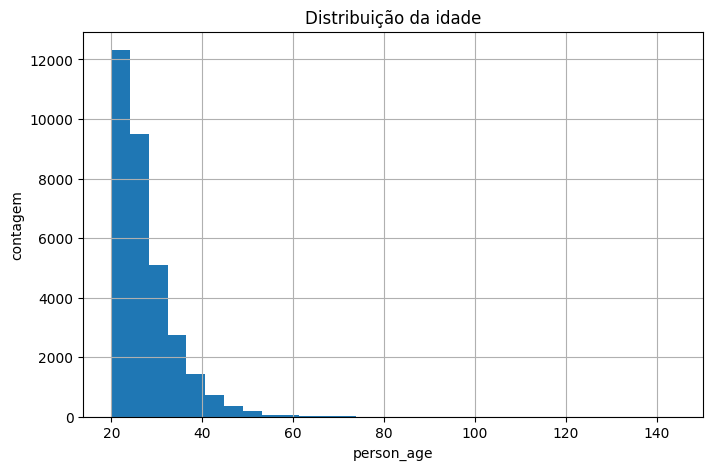

In [ ]:
# mostrar o risco de crédito conforme a idade
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(credit_risk['person_age'].dropna(), bins=30)
plt.title("Distribuição da idade")
plt.xlabel("person_age")
plt.ylabel("contagem")
plt.grid(True)
plt.show()


In [ ]:
# 4) Preparações iniciais
# Converter cb_person_default_on_file de Y/N para 1/0 (se existir)
if 'cb_person_default_on_file' in credit_risk.columns:
    credit_risk['cb_person_default_on_file'] = (
        credit_risk['cb_person_default_on_file']
            .astype(str)
            .str.strip()
            .str.upper()
            .map({'Y': 1, 'N': 0})
    )
    print("cb_person_default_on_file convertida para 0/1 (quando aplicável).")

# Detectar coluna alvo: usar 'target' se já existir; senão buscar 'loan_status' etc.
if 'target' in credit_risk.columns:
    print("Usando coluna 'target' como alvo.")
    target_col = 'target'
elif 'loan_status' in credit_risk.columns:
    credit_risk = credit_risk.rename(columns={'loan_status':'target'})
    target_col = 'target'
    print("Renomeado 'loan_status' para 'target'.")
else:
    # heurística: coluna binária numérica com 0/1
    candidate = None
    for col in credit_risk.columns:
        if pd.api.types.is_numeric_dtype(credit_risk[col]):
            uniques = pd.Series(credit_risk[col].dropna().unique())
            if set(uniques).issubset({0,1}) or len(uniques) == 2:
                candidate = col
                break
    if candidate:
        credit_risk = credit_risk.rename(columns={candidate:'target'})
        target_col = 'target'
        print(f"Alvo detectado por heurística e renomeado: {candidate} -> target")
    else:
        raise KeyError("Não foi possível detectar automaticamente a coluna alvo. Verifique o dataset.")

# Mostrar distribuição do target
print("\nDistribuição do target:")
print(credit_risk['target'].value_counts(dropna=False))
print("\n%:")
print((credit_risk['target'].value_counts(normalize=True)*100).round(2))


cb_person_default_on_file convertida para 0/1 (quando aplicável).
Usando coluna 'target' como alvo.

Distribuição do target:
target
0    25473
1     7108
Name: count, dtype: int64

%:
target
0    78.18
1    21.82
Name: proportion, dtype: float64


#### 4. Separação entre Features (X) e Target (y)

Aqui definimos:
- `X` → todas as colunas usadas como entrada no modelo.
- `y` → coluna que queremos prever (`target`).


In [ ]:
# 4) Separar X e y
X = credit_risk.drop(columns=['target'])
y = credit_risk['target']

# divisão treino/teste estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shapes -> X_train:", X_train.shape, " X_test:", X_test.shape)


Shapes -> X_train: (26064, 11)  X_test: (6517, 11)


#### 5. Identificando colunas numéricas e categóricas

O Pandas classifica automaticamente os tipos das colunas.  
Aqui separamos:

- `num_cols`: variáveis numéricas (podem receber scaler)
- `cat_cols`: variáveis categóricas (precisam de OneHotEncoder)


In [ ]:
# 5) Identificar colunas numéricas e categóricas
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# transformar pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')


Numéricas: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
Categóricas: ['person_home_ownership', 'loan_intent', 'loan_grade']


#### 6. Criando o Pipeline de Pré-processamento + Balanceamento + Modelo

Pipeline faz tudo automaticamente:

| Operação | O que faz |
|----------|-----------|
| Imputer | Preenche valores ausentes |
| Scaler | Ajusta escala das variáveis numéricas |
| OneHotEncoder | Converte texto em números |
| SMOTE | Balanceia classes desbalanceadas |
| RandomForestClassifier | Treina o modelo final |

Assim evitamos erros e garantimos que o mesmo pré-processamento será aplicado nos dados de treino e teste.


In [ ]:
# 6) Construir pipeline com RandomForest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

if imblearn_available:
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', rf)
    ])
    print("Pipeline com SMOTE criada.")
else:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ])
    print("imblearn não disponível: usando RandomForest com class_weight='balanced' no pipeline.")


Pipeline com SMOTE criada.


#### 7. Treinamento e Avaliação do Modelo

Nesta etapa:
- treinamos o modelo com `pipeline.fit()`
- fazemos previsões
- avaliamos o desempenho com:
  - accuracy
  - recall
  - precision
  - matriz de confusão

É aqui que validamos se o modelo realmente tem boa capacidade de classificação.


Classification report (teste):
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.94      0.73      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.93      0.86      0.89      6517
weighted avg       0.93      0.93      0.93      6517



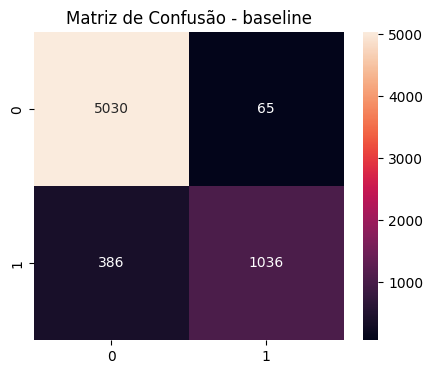

ROC AUC (baseline): 0.9293489797918315


In [ ]:
# 7) Treinamento inicial (sem busca de hiperparâmetros)
pipeline.fit(X_train, y_train)

# Previsões no teste
y_pred = pipeline.predict(X_test)
try:
    y_prob = pipeline.predict_proba(X_test)[:,1]
except Exception:
    y_prob = None

# Relatório e matriz
print("Classification report (teste):")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Matriz de Confusão - baseline")
plt.show()

if y_prob is not None:
    print("ROC AUC (baseline):", roc_auc_score(y_test, y_prob))


In [ ]:
# 8) RandomizedSearchCV (rápido) - ajuste de hiperparâmetros
param_dist = {
    'clf__n_estimators': randint(50, 300),
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': randint(2, 10),
    'clf__min_samples_leaf': randint(1, 5),
    'clf__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,               # número de amostras do espaço de busca (ajuste aqui)
    scoring='f1',            # podemos trocar por 'recall' se preferir capturar mais positivos
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Iniciando RandomizedSearchCV...")
random_search.fit(X_train, y_train)
print("RandomizedSearchCV finalizado.")
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)


Iniciando RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomizedSearchCV finalizado.
Melhores parâmetros encontrados:
{'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 216}


Classification report (melhor modelo):
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.95      0.73      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.93      0.93      0.93      6517



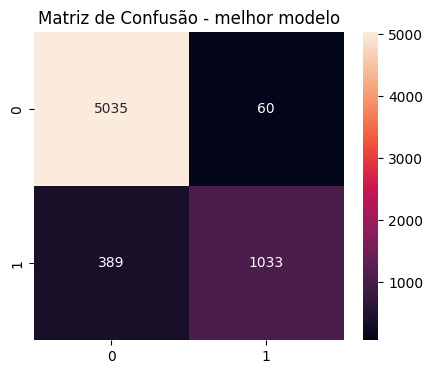

ROC AUC (melhor modelo): 0.9302215707465333


In [ ]:
# 9) Avaliar melhor modelo no conjunto de teste
best_model = random_search.best_estimator_

y_pred_best = best_model.predict(X_test)
try:
    y_prob_best = best_model.predict_proba(X_test)[:,1]
except Exception:
    y_prob_best = None

print("Classification report (melhor modelo):")
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Matriz de Confusão - melhor modelo")
plt.show()

if y_prob_best is not None:
    print("ROC AUC (melhor modelo):", roc_auc_score(y_test, y_prob_best))


loan_percent_income                0.199045
person_income                      0.133308
loan_int_rate                      0.127489
loan_amnt                          0.067640
loan_grade__D                      0.063733
person_home_ownership__RENT        0.053207
person_emp_length                  0.051772
cb_person_cred_hist_length         0.044876
person_age                         0.042111
person_home_ownership__MORTGAGE    0.032334
loan_grade__A                      0.021608
person_home_ownership__OWN         0.019908
loan_intent__HOMEIMPROVEMENT       0.019282
loan_grade__C                      0.018048
loan_intent__VENTURE               0.015550
loan_intent__MEDICAL               0.015536
loan_intent__DEBTCONSOLIDATION     0.014502
loan_grade__E                      0.013964
loan_intent__EDUCATION             0.011845
cb_person_default_on_file          0.010862
dtype: float64

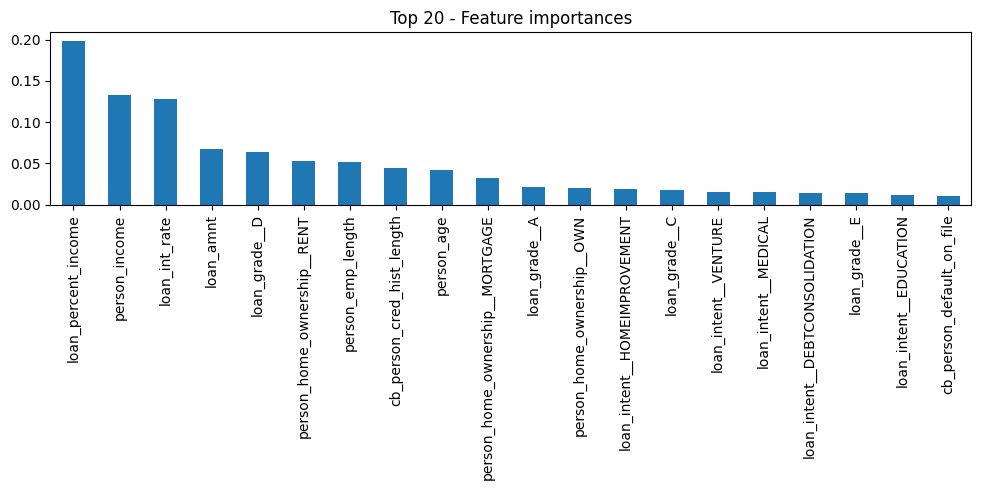

In [ ]:
# 10) Importância das features (quando o clf fornece feature_importances_)
clf_used = best_model.named_steps['clf']
preproc_used = best_model.named_steps['preprocessor']

def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []
    for name, transformer, cols in column_transformer.transformers_:
        if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
            ohe = transformer.named_steps['onehot']
            cats = ohe.categories_
            for i, col in enumerate(cols):
                feature_names.extend([f"{col}__{c}" for c in cats[i]])
        else:
            feature_names.extend(cols)
    return feature_names

if hasattr(clf_used, 'feature_importances_'):
    feat_names = get_feature_names_from_column_transformer(preproc_used)
    importances = pd.Series(clf_used.feature_importances_, index=feat_names).sort_values(ascending=False)
    display(importances.head(20))
    plt.figure(figsize=(10,5))
    importances.head(20).plot(kind='bar')
    plt.title("Top 20 - Feature importances")
    plt.tight_layout()
    plt.show()
else:
    print("O classificador não fornece feature_importances_.")


In [ ]:
# 11) Salvar o modelo final em arquivo .pkl
joblib.dump(best_model, 'modelo_risco_credito_best_random.pkl')
print("Modelo salvo: modelo_risco_credito_best_random.pkl")


Modelo salvo: modelo_risco_credito_best_random.pkl


#### ✅ Conclusões do Projeto

- Construímos um modelo completo para **classificação de risco de crédito**.
- Utilizamos técnicas profissionais de pré-processamento e balanceamento.
- O uso de Pipeline garante reprodutibilidade e organização.
- SMOTE evita que o modelo aprenda apenas a classe majoritária.
